<a href="https://colab.research.google.com/github/tanya58/Leaf-Disease-Detection/blob/main/leaf_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import keras
import PIL
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from matplotlib.image import imread
import matplotlib.pyplot as plt
import cv2
import random
import os
from os import listdir
from PIL import Image
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical
from IPython.display import HTML
import pandas as pd
import numpy as np




In [ ]:
PIL.__version__

'9.4.0'

In [ ]:
print(tf.__version__)

2.17.0


In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Tanya/test",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE




)

Found 1099 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Apple___Cedar_apple_rust', 'Apple___healthy', 'Potato___Early_blight']

In [ ]:
len(dataset)

35

In [ ]:
64*32

2048

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 1 0 2 0 0 1 0 0 2 2 0 0 0 0 1 1 1 1 2 1 1 0 1 1 0 1 1 1 1]


In [ ]:
for image_batch, label_batch in dataset.take(1):
   print(image_batch[0].numpy())


[[[117.  99.  97.]
  [126. 108. 106.]
  [119. 101.  99.]
  ...
  [147. 127. 126.]
  [158. 138. 137.]
  [161. 141. 140.]]

 [[116.  98.  96.]
  [ 85.  67.  65.]
  [109.  91.  89.]
  ...
  [129. 109. 108.]
  [123. 103. 102.]
  [147. 127. 126.]]

 [[114.  96.  94.]
  [ 96.  78.  76.]
  [168. 150. 148.]
  ...
  [141. 121. 120.]
  [138. 118. 117.]
  [156. 136. 135.]]

 ...

 [[200. 192. 189.]
  [201. 193. 190.]
  [202. 194. 191.]
  ...
  [171. 160. 158.]
  [173. 162. 160.]
  [171. 160. 158.]]

 [[202. 194. 191.]
  [200. 192. 189.]
  [199. 191. 188.]
  ...
  [178. 167. 165.]
  [177. 166. 164.]
  [173. 162. 160.]]

 [[198. 190. 187.]
  [195. 187. 184.]
  [193. 185. 182.]
  ...
  [181. 170. 168.]
  [178. 167. 165.]
  [171. 160. 158.]]]


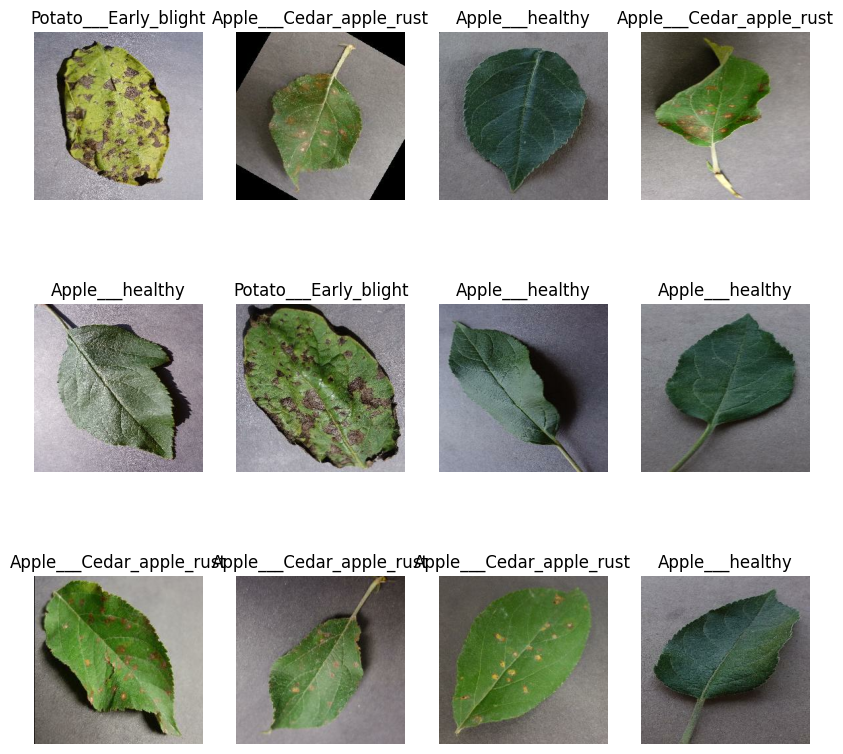

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):

    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

35

In [ ]:
train_size = 0.8
len(dataset)*train_size

28.0

In [ ]:
train_ds = dataset.take(28)
len(train_ds)

28

In [ ]:
test_ds = dataset.skip(28)
len(test_ds)

7

In [ ]:
val_size=0.1
len(dataset)*val_size

3.5

In [ ]:
val_ds= test_ds.take(3)
len(val_ds)

3

In [ ]:
test_ds = test_ds.skip(3)
len(test_ds)

4

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size= 10000):

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

28

In [ ]:
len(val_ds)

3

In [ ]:
len(test_ds)

4

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),




])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [ ]:
!pip install keras-utils

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)


In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
import numpy as np


In [ ]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print(" actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0) # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])),2)
    return predicted_class, confidence




In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
import numpy as np


In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


In [ ]:
!mount /content/drive/my Drive

In [ ]:
from keras.models import load_model

model = load_model("/content/models.h4")

In [ ]:
acc = model.evaluate_generator(dataset)[1]

print(f"the accuracy of your model is = {acc*100} %")

In [ ]:
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/saved models/content/models.h4')